In [31]:
from loader import get_nn_patients

In [32]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical #hot-encoding

### Preparing the data
Important observations:
data for a given group (train or test) must be given to CNN into a single three-dimensional NumPy array, where the dimensions of the array are [samples, time steps, features], where sample: one input example that has 1 or more time steps with one or more features at each time step; time steps: one part of a single input example that has one or more features; feature: one of possible many observations for a given time step.


In [33]:
radars, mats, patients, x, _,  y , _= get_nn_patients()

In [34]:
radars.shape, mats.shape, patients.shape, x.shape, y.shape

((50, 857), (50, 857), (50, 857, 3), (50, 857, 2), (50, 857))

In [35]:
trainX, trainy = x[:34,:,:], y[:34,:]
testX, testy = x[34:,:,:], y[34:,:]
trainX.shape, trainy.shape, testX.shape, testy.shape

((34, 857, 2), (34, 857), (16, 857, 2), (16, 857))

In [36]:
trainX = trainX.reshape(29138,1,2)
trainy = trainy.reshape(29138)
testX = testX.reshape(13712,1,2)
testy = testy.reshape(13712)

trainX = trainX.reshape(857,34,2)
trainy = trainy[1,:].reshape(857)
testX = testX.reshape(857,16,2)
testy = testy[1,:].reshape(857)

In [37]:
trainy = to_categorical(trainy)
testy = to_categorical(testy)

In [38]:
trainX.shape, trainy.shape, testX.shape, testy.shape

((29138, 1, 2), (29138, 4), (13712, 1, 2), (13712, 4))

### Fitting the CNN model 
We will define the model as having two 1D CNN layers, followed by a dropout layer for regularization, then a pooling layer. It is common to define CNN layers in groups of two in order to give the model a good chance of learning features from the input data. CNNs learn very quickly, so the dropout layer is intended to help slow down the learning process and hopefully result in a better final model. The pooling layer reduces the learned features to 1/4 their size, consolidating them to only the most essential elements.

After the CNN and pooling, the learned features are flattened to one long vector and pass through a fully connected layer before the output layer used to make a prediction. The fully connected layer ideally provides a buffer between the learned features and the output with the intent of interpreting the learned features before making a prediction.

In [29]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features), padding = 'same'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(0.5))
    

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    print(model.summary())
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)
    return accuracy

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(repeats=10):
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

# run the experiment
run_experiment()

Model: "sequential_164"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_335 (Conv1D)         (None, 1, 64)             640       
                                                                 
 max_pooling1d_175 (MaxPooli  (None, 1, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_336 (Conv1D)         (None, 1, 64)             12352     
                                                                 
 max_pooling1d_176 (MaxPooli  (None, 1, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_337 (Conv1D)         (None, 1, 64)             12352     
                                                                 
 max_pooling1d_177 (MaxPooli  (None, 1, 64)         

2022-12-20 21:38:35.127822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 21:40:25.488950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#1: 66.190
Model: "sequential_165"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_338 (Conv1D)         (None, 1, 64)             640       
                                                                 
 max_pooling1d_178 (MaxPooli  (None, 1, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_339 (Conv1D)         (None, 1, 64)             12352     
                                                                 
 max_pooling1d_179 (MaxPooli  (None, 1, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_340 (Conv1D)         (None, 1, 64)             12352     
                                                                 
 max_pooling1d_180 (MaxPooli  (None, 1, 

2022-12-20 21:40:30.032029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 21:42:17.332092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#2: 64.141
Model: "sequential_166"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_341 (Conv1D)         (None, 1, 64)             640       
                                                                 
 max_pooling1d_181 (MaxPooli  (None, 1, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_342 (Conv1D)         (None, 1, 64)             12352     
                                                                 
 max_pooling1d_182 (MaxPooli  (None, 1, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_343 (Conv1D)         (None, 1, 64)             12352     
                                                                 
 max_pooling1d_183 (MaxPooli  (None, 1, 

2022-12-20 21:42:21.710298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 21:44:09.016592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#3: 65.023
Model: "sequential_167"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_344 (Conv1D)         (None, 1, 64)             640       
                                                                 
 max_pooling1d_184 (MaxPooli  (None, 1, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_345 (Conv1D)         (None, 1, 64)             12352     
                                                                 
 max_pooling1d_185 (MaxPooli  (None, 1, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_346 (Conv1D)         (None, 1, 64)             12352     
                                                                 
 max_pooling1d_186 (MaxPooli  (None, 1, 

2022-12-20 21:44:13.580436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 21:46:03.909346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#4: 66.249
Model: "sequential_168"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_347 (Conv1D)         (None, 1, 64)             640       
                                                                 
 max_pooling1d_187 (MaxPooli  (None, 1, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_348 (Conv1D)         (None, 1, 64)             12352     
                                                                 
 max_pooling1d_188 (MaxPooli  (None, 1, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_349 (Conv1D)         (None, 1, 64)             12352     
                                                                 
 max_pooling1d_189 (MaxPooli  (None, 1, 

2022-12-20 21:46:08.428001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 21:47:57.372925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#5: 63.266
Model: "sequential_169"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_350 (Conv1D)         (None, 1, 64)             640       
                                                                 
 max_pooling1d_190 (MaxPooli  (None, 1, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_351 (Conv1D)         (None, 1, 64)             12352     
                                                                 
 max_pooling1d_191 (MaxPooli  (None, 1, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_352 (Conv1D)         (None, 1, 64)             12352     
                                                                 
 max_pooling1d_192 (MaxPooli  (None, 1, 

2022-12-20 21:48:02.128407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 21:49:49.604771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#6: 64.272
Model: "sequential_170"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_353 (Conv1D)         (None, 1, 64)             640       
                                                                 
 max_pooling1d_193 (MaxPooli  (None, 1, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_354 (Conv1D)         (None, 1, 64)             12352     
                                                                 
 max_pooling1d_194 (MaxPooli  (None, 1, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_355 (Conv1D)         (None, 1, 64)             12352     
                                                                 
 max_pooling1d_195 (MaxPooli  (None, 1, 

2022-12-20 21:49:54.109252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 21:51:41.453126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#7: 64.775
Model: "sequential_171"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_356 (Conv1D)         (None, 1, 64)             640       
                                                                 
 max_pooling1d_196 (MaxPooli  (None, 1, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_357 (Conv1D)         (None, 1, 64)             12352     
                                                                 
 max_pooling1d_197 (MaxPooli  (None, 1, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_358 (Conv1D)         (None, 1, 64)             12352     
                                                                 
 max_pooling1d_198 (MaxPooli  (None, 1, 

2022-12-20 21:51:45.897599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 21:53:34.974720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#8: 63.186
Model: "sequential_172"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_359 (Conv1D)         (None, 1, 64)             640       
                                                                 
 max_pooling1d_199 (MaxPooli  (None, 1, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_360 (Conv1D)         (None, 1, 64)             12352     
                                                                 
 max_pooling1d_200 (MaxPooli  (None, 1, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_361 (Conv1D)         (None, 1, 64)             12352     
                                                                 
 max_pooling1d_201 (MaxPooli  (None, 1, 

2022-12-20 21:53:39.751198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 21:55:29.133012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#9: 64.170
Model: "sequential_173"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_362 (Conv1D)         (None, 1, 64)             640       
                                                                 
 max_pooling1d_202 (MaxPooli  (None, 1, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_363 (Conv1D)         (None, 1, 64)             12352     
                                                                 
 max_pooling1d_203 (MaxPooli  (None, 1, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_364 (Conv1D)         (None, 1, 64)             12352     
                                                                 
 max_pooling1d_204 (MaxPooli  (None, 1, 

2022-12-20 21:55:33.640839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 21:57:28.145119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#10: 64.382
[66.19020104408264, 64.14089798927307, 65.02333879470825, 66.2485420703888, 63.2657527923584, 64.27217125892639, 64.77537751197815, 63.1855309009552, 64.17006850242615, 64.38156366348267]
Accuracy: 64.565% (+/-0.989)


### Tuning the number of filters

2022-12-20 13:48:13.729891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 13:49:18.256654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=8 #1: 55.652


2022-12-20 13:49:20.765278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 13:50:25.964517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=8 #2: 46.193


2022-12-20 13:50:28.478288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 13:51:34.346730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=8 #3: 62.682


2022-12-20 13:51:36.886056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 13:52:42.664819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=8 #4: 59.977


2022-12-20 13:52:45.186438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 13:53:52.301481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=8 #5: 63.244


2022-12-20 13:53:54.879244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 13:55:02.463545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=8 #6: 63.244


2022-12-20 13:55:05.055431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 13:56:12.060602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=8 #7: 63.244


2022-12-20 13:56:14.633813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 13:57:21.478041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=8 #8: 50.314


2022-12-20 13:57:24.045776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 13:58:31.498688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=8 #9: 63.244


2022-12-20 13:58:34.357271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 13:59:41.438621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=8 #10: 50.394


2022-12-20 13:59:44.046111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:00:58.144395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=16 #1: 63.244


2022-12-20 14:01:00.753809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:02:14.161096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=16 #2: 63.324


2022-12-20 14:02:17.169573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:03:30.246896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=16 #3: 63.324


2022-12-20 14:03:33.091363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:04:44.598501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=16 #4: 50.394


2022-12-20 14:04:47.272695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:05:58.794993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=16 #5: 62.763


2022-12-20 14:06:01.556436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:07:12.409440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=16 #6: 63.324


2022-12-20 14:07:15.169287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:08:28.312948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=16 #7: 63.324


2022-12-20 14:08:31.187429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:09:45.181410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=16 #8: 60.575


2022-12-20 14:09:48.116251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:14:28.102658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=16 #9: 63.324


2022-12-20 14:14:31.027225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:15:45.213942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=16 #10: 63.324


2022-12-20 14:15:48.586505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:17:01.193468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=32 #1: 65.271


2022-12-20 14:17:04.137861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:18:17.712109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=32 #2: 63.310


2022-12-20 14:18:20.577558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:19:34.539309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=32 #3: 63.324


2022-12-20 14:19:37.409276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:20:51.097651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=32 #4: 63.244


2022-12-20 14:20:54.049554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:22:08.383848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=32 #5: 63.324


2022-12-20 14:22:11.317030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:23:26.089165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=32 #6: 65.286


2022-12-20 14:23:28.973208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:24:43.225913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=32 #7: 62.763


2022-12-20 14:24:46.115267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:26:00.073627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=32 #8: 63.324


2022-12-20 14:26:02.998824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:27:16.929472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=32 #9: 63.324


2022-12-20 14:27:19.829139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:28:33.676446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=32 #10: 62.763


2022-12-20 14:28:36.856797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:29:54.094341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=64 #1: 65.271


2022-12-20 14:29:57.066084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:31:14.151912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=64 #2: 65.833


2022-12-20 14:31:17.091559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:32:33.162634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=64 #3: 65.271


2022-12-20 14:32:36.054062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:33:51.424508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=64 #4: 65.833


2022-12-20 14:33:54.389614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:35:10.440546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=64 #5: 65.833


2022-12-20 14:35:13.383147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:36:29.146804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=64 #6: 65.286


2022-12-20 14:36:32.061910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:37:48.570285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=64 #7: 66.394


2022-12-20 14:37:51.784625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:39:08.625905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=64 #8: 65.833


2022-12-20 14:39:11.530912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:40:27.539304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=64 #9: 65.271


2022-12-20 14:40:30.475328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:41:47.444910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=64 #10: 65.833


2022-12-20 14:41:50.405335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:43:06.677242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=128 #1: 66.394


2022-12-20 14:43:09.879324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:44:27.132081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=128 #2: 64.433


2022-12-20 14:44:30.160716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:45:45.739473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=128 #3: 65.833


2022-12-20 14:45:48.819642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:47:04.835860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=128 #4: 65.096


2022-12-20 14:47:07.955394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:48:22.633664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=128 #5: 64.549


2022-12-20 14:48:25.547336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:49:40.003903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=128 #6: 65.658


2022-12-20 14:49:43.059491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:50:58.736880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=128 #7: 65.096


2022-12-20 14:51:01.868538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:52:17.924498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=128 #8: 66.394


2022-12-20 14:52:20.973079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:53:38.823578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=128 #9: 65.833


2022-12-20 14:53:42.010835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:54:59.968972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=128 #10: 65.658


2022-12-20 14:55:03.216579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:56:22.210582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=256 #1: 65.658


2022-12-20 14:56:26.374573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:57:47.439781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=256 #2: 61.136


2022-12-20 14:57:50.737716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 14:59:09.496468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=256 #3: 65.658


2022-12-20 15:02:49.658232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:04:10.788842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=256 #4: 65.096


2022-12-20 15:04:14.136389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:05:34.107594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=256 #5: 66.394


2022-12-20 15:05:37.352553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:06:55.581054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=256 #6: 65.658


2022-12-20 15:06:58.820967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:08:17.347449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=256 #7: 66.394


2022-12-20 15:08:20.687196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:09:39.277565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=256 #8: 65.286


2022-12-20 15:09:42.431348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:11:01.629460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=256 #9: 65.096


2022-12-20 15:11:04.963814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:12:25.195586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=256 #10: 63.871
[[55.651986598968506, 46.193116903305054, 62.68232464790344, 59.97666120529175, 63.24387192726135, 63.24387192726135, 63.24387192726135, 50.313591957092285, 63.24387192726135, 50.39381384849548], [63.24387192726135, 63.32409381866455, 63.32409381866455, 50.39381384849548, 62.76254653930664, 63.32409381866455, 63.32409381866455, 60.57468056678772, 63.32409381866455, 63.32409381866455], [65.27129411697388, 63.30950856208801, 63.32409381866455, 63.24387192726135, 63.32409381866455, 65.28587937355042, 62.76254653930664, 63.32409381866455, 63.32409381866455, 62.76254653930664], [65.27129411697388, 65.83284735679626, 65.27129411697388, 65.83284735679626, 65.83284735679626, 65.28587937355042, 66.39440059661865, 65.83284735679626, 65.27129411697388, 65.83284735679626], [66.39440059661865, 64.43261504173279, 65.83284735679626, 65.09626507759094, 64.54930305480957, 65.65781831741333, 65.09626507759094, 66.39440059661865, 65.83284735679626, 65.65781831741333], [65.6578183174133

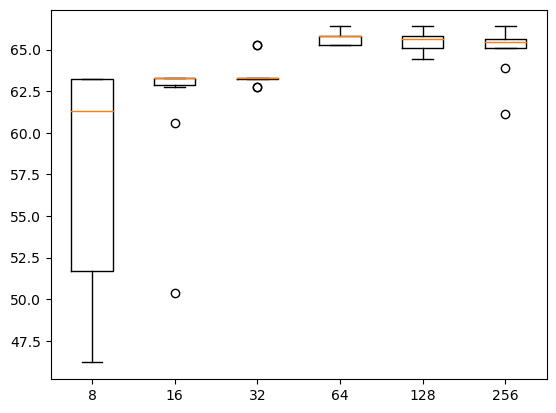

In [10]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, n_filters):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features), padding = "same"))
    model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu', padding = "same"))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

# summarize scores
def summarize_results(scores, params):
    print(scores, params)
    # summarize mean and standard deviation
    for i in range(len(scores)):
        m, s = mean(scores[i]), std(scores[i])
        print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
    # boxplot of scores
    pyplot.boxplot(scores, labels=params)
    pyplot.savefig('exp_cnn_filters.png')

# run an experiment
def run_experiment(params, repeats=10):

    # test each parameter
    all_scores = list()
    for p in params:
        # repeat experiment
        scores = list()
        for r in range(repeats):
            score = evaluate_model(trainX, trainy, testX, testy, p)
            score = score * 100.0
            print('>p=%d #%d: %.3f' % (p, r+1, score))
            scores.append(score)
        all_scores.append(scores)
    # summarize results
    summarize_results(all_scores, params)

# run the experiment
n_params = [8, 16, 32, 64, 128, 256]
run_experiment(n_params)

### Tuning size of kernel

2022-12-20 15:12:29.131306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:14:26.351535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=2 #1: 65.271


2022-12-20 15:14:29.768776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:16:28.350158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=2 #2: 64.724


2022-12-20 15:16:31.606494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:18:29.432843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=2 #3: 66.394


2022-12-20 15:18:32.710085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:20:30.890333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=2 #4: 65.833


2022-12-20 15:20:34.163680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:22:34.722838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=2 #5: 66.394


2022-12-20 15:22:38.112299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:24:39.656719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=2 #6: 66.394


2022-12-20 15:24:43.038330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:26:44.080261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=2 #7: 65.096


2022-12-20 15:26:47.503130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:28:48.706463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=2 #8: 65.271


2022-12-20 15:28:52.130379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:30:54.406885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=2 #9: 64.608


2022-12-20 15:30:57.832148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:32:58.920476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=2 #10: 65.096


2022-12-20 15:33:02.323476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:35:04.352179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=3 #1: 66.394


2022-12-20 15:35:08.303200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:37:10.337660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=3 #2: 65.833


2022-12-20 15:37:13.735654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:39:16.161105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=3 #3: 65.833


2022-12-20 15:39:19.577752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:41:22.518440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=3 #4: 65.271


2022-12-20 15:41:25.933649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:43:29.001041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=3 #5: 66.394


2022-12-20 15:43:32.446445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:45:35.636635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=3 #6: 65.096


2022-12-20 15:45:39.060986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:47:42.873898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=3 #7: 65.833


2022-12-20 15:47:46.325022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:49:50.716722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=3 #8: 64.724


2022-12-20 15:49:54.195420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:51:58.220929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=3 #9: 65.286


2022-12-20 15:52:01.667280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:54:06.057385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=3 #10: 65.833


2022-12-20 15:54:09.575207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:56:13.333249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=5 #1: 65.833


2022-12-20 15:56:17.343453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 15:58:22.069858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=5 #2: 65.833


2022-12-20 15:58:25.591406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:00:30.243878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=5 #3: 65.833


2022-12-20 16:00:33.687364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:02:38.459639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=5 #4: 65.096


2022-12-20 16:02:41.914080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:04:45.949947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=5 #5: 65.833


2022-12-20 16:04:49.426146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:06:53.770317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=5 #6: 66.394


2022-12-20 16:06:57.246553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:09:01.891321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=5 #7: 66.394


2022-12-20 16:09:05.381139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:11:09.740655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=5 #8: 65.833


2022-12-20 16:11:13.167580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:13:16.961696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=5 #9: 65.271


2022-12-20 16:13:20.405998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:15:23.739120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=5 #10: 65.096


2022-12-20 16:15:27.208028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:17:31.406992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=7 #1: 65.833


2022-12-20 16:17:34.829074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:19:38.746763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=7 #2: 64.724


2022-12-20 16:19:42.295887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:21:47.895418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=7 #3: 65.833


2022-12-20 16:21:51.366050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:23:57.685123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=7 #4: 65.111


2022-12-20 16:24:01.156140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:26:06.263091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=7 #5: 66.394


2022-12-20 16:26:09.757264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:28:14.405171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=7 #6: 65.833


2022-12-20 16:28:17.907493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:30:23.563377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=7 #7: 65.847


2022-12-20 16:30:27.079364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:32:34.231005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=7 #8: 65.286


2022-12-20 16:32:37.694728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:34:43.559906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=7 #9: 65.111


2022-12-20 16:34:46.995356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:36:52.152005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=7 #10: 65.833


2022-12-20 16:36:55.599880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:38:59.538575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=11 #1: 63.660


2022-12-20 16:39:02.951744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:41:06.830712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=11 #2: 65.847


2022-12-20 16:41:11.706938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:43:21.718991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=11 #3: 63.098


2022-12-20 16:43:25.234667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:45:31.964447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=11 #4: 66.394


2022-12-20 16:45:35.395592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:47:41.057944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=11 #5: 65.833


2022-12-20 16:47:44.508843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 16:52:15.812676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=11 #6: 65.833


2022-12-20 16:52:19.204401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 17:33:16.147526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=11 #7: 62.361


2022-12-20 17:33:50.488093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:02:53.725866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=11 #8: 65.833


2022-12-20 18:02:57.103036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:05:02.975952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=11 #9: 63.098


2022-12-20 18:05:06.383224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:07:17.456357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>p=11 #10: 65.833
[[65.27129411697388, 64.7243320941925, 66.39440059661865, 65.83284735679626, 66.39440059661865, 66.39440059661865, 65.09626507759094, 65.27129411697388, 64.60764408111572, 65.09626507759094], [66.39440059661865, 65.83284735679626, 65.83284735679626, 65.27129411697388, 66.39440059661865, 65.09626507759094, 65.83284735679626, 64.7243320941925, 65.28587937355042, 65.83284735679626], [65.83284735679626, 65.83284735679626, 65.83284735679626, 65.09626507759094, 65.83284735679626, 66.39440059661865, 66.39440059661865, 65.83284735679626, 65.27129411697388, 65.09626507759094], [65.83284735679626, 64.7243320941925, 65.83284735679626, 65.11085033416748, 66.39440059661865, 65.83284735679626, 65.8474326133728, 65.28587937355042, 65.11085033416748, 65.83284735679626], [63.65956664085388, 65.8474326133728, 63.09801936149597, 66.39440059661865, 65.83284735679626, 65.83284735679626, 62.36143708229065, 65.83284735679626, 63.09801936149597, 65.83284735679626]] [2, 3, 5, 7, 11]
Param=2: 

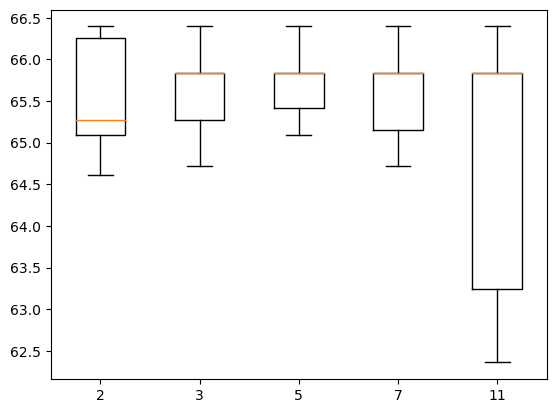

In [11]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, n_kernel):
    verbose, epochs, batch_size = 0, 15, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=n_kernel, activation='relu', input_shape=(n_timesteps,n_features), padding = "same"))
    model.add(Conv1D(filters=64, kernel_size=n_kernel, activation='relu', padding = "same"))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

# summarize scores
def summarize_results(scores, params):
    print(scores, params)
    # summarize mean and standard deviation
    for i in range(len(scores)):
        m, s = mean(scores[i]), std(scores[i])
        print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
    # boxplot of scores
    pyplot.boxplot(scores, labels=params)
    pyplot.savefig('exp_cnn_kernel.png')

# run an experiment
def run_experiment(params, repeats=10):

    # test each parameter
    all_scores = list()
    for p in params:
        # repeat experiment
        scores = list()
        for r in range(repeats):
            score = evaluate_model(trainX, trainy, testX, testy, p)
            score = score * 100.0
            print('>p=%d #%d: %.3f' % (p, r+1, score))
            scores.append(score)
        all_scores.append(scores)
    # summarize results
    summarize_results(all_scores, params)

# run the experiment
n_params = [2, 3, 5, 7, 11]
run_experiment(n_params)

### Running the CNN with the tuned parameters, filter = 64, kernel size = 11

In [44]:
#fit and evaluate a model
filters = 64
kernel_size = 11
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters, kernel_size, activation='relu', input_shape=(n_timesteps,n_features), padding = 'same'))
    model.add(Conv1D(filters, kernel_size, activation='relu', padding = 'same'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)
    return accuracy

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(repeats=10):
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

# run the experiment
run_experiment()

2022-12-21 18:13:09.958917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-21 18:14:56.252344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#1: 65.286


2022-12-21 18:15:00.750258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-21 18:16:50.157193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#2: 66.394


2022-12-21 18:16:54.706810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-21 18:18:40.217093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#3: 66.394


2022-12-21 18:18:44.599212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-21 18:20:28.828493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#4: 63.871


2022-12-21 18:20:33.176896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-21 18:31:20.836148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#5: 65.271


2022-12-21 18:31:25.098535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-21 18:33:07.835543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#6: 66.394


2022-12-21 18:33:12.523250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-21 18:34:55.356483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#7: 66.394


2022-12-21 18:35:00.028055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-21 18:36:43.620155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#8: 65.833


2022-12-21 18:36:47.913563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-21 18:38:29.968541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#9: 65.833


2022-12-21 18:38:34.238868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-21 18:40:18.513425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#10: 65.833
[65.28587937355042, 66.39440059661865, 66.39440059661865, 63.8710618019104, 65.27129411697388, 66.39440059661865, 66.39440059661865, 65.83284735679626, 65.83284735679626, 65.83284735679626]
Accuracy: 65.750% (+/-0.752)


### Multi - headed CNN

In [43]:
# multi-headed cnn
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import concatenate


# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # head 1
    inputs1 = Input(shape=(n_timesteps,n_features))
    conv1_1 = Conv1D(filters=64, kernel_size=5, activation='relu', padding = "same")(inputs1)
    drop1_1 = Dropout(0.5)(conv1_1)
    conv1_2 = Conv1D(filters=64, kernel_size=5, activation='relu', padding = "same")(inputs1)
    drop1_2 = Dropout(0.5)(conv1_2)
    flat1 = Flatten()(drop1_2)
    # head 2
    inputs2 = Input(shape=(n_timesteps,n_features))
    conv2_1 = Conv1D(filters=128, kernel_size=7, activation='relu', padding = "same")(inputs2)
    drop2_1 = Dropout(0.5)(conv2_1)
    conv2_2 = Conv1D(filters=128, kernel_size=7, activation='relu', padding = "same")(inputs2)
    drop2_2 = Dropout(0.5)(conv2_2)
    flat2 = Flatten()(drop2_2)
    # head 3
    inputs3 = Input(shape=(n_timesteps,n_features))
    conv3_1 = Conv1D(filters=256, kernel_size=11, activation='relu', padding = "same")(inputs3)
    drop3_1 = Dropout(0.5)(conv3_1)
    conv3_2 = Conv1D(filters=256, kernel_size=11, activation='relu', padding = "same")(inputs3)
    drop3_2 = Dropout(0.5)(conv3_2)
    flat3 = Flatten()(drop3_2)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(100, activation='relu')(merged)
    outputs = Dense(n_outputs, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # save a plot of the model
    plot_model(model, show_shapes=True, to_file='multichannel.png')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit([trainX,trainX,trainX], trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate([testX,testX,testX], testy, batch_size=batch_size, verbose=0)
    return (accuracy)

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(repeats=10):
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    return summarize_results(scores)

# run the experiment
run_experiment()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2022-12-21 17:53:10.166994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-21 17:55:03.373347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#1: 66.394
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2022-12-21 17:55:07.792053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-21 17:56:58.187881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#2: 66.394
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2022-12-21 17:57:03.016926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-21 17:58:55.782664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#3: 65.096
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2022-12-21 17:59:00.265128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-21 18:00:52.383951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#4: 65.096
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2022-12-21 18:00:56.980868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-21 18:02:49.556030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#5: 66.394
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2022-12-21 18:02:54.011088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-21 18:04:50.245739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#6: 65.833
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2022-12-21 18:04:55.090690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-21 18:06:52.162647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#7: 63.871
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2022-12-21 18:06:56.880059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-21 18:08:53.751206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#8: 65.833
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2022-12-21 18:08:58.482227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-21 18:10:56.857480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#9: 66.394
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2022-12-21 18:11:01.941535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-21 18:13:05.230666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#10: 66.394
[66.39440059661865, 66.39440059661865, 65.09626507759094, 65.09626507759094, 66.39440059661865, 65.83284735679626, 63.8710618019104, 65.83284735679626, 66.39440059661865, 66.39440059661865]
Accuracy: 65.770% (+/-0.804)


### Trying with the two different augmentation (small and big)

In [14]:
radars, mats, patients, x_small, x_big, y_small, y_big = get_nn_patients(divided = True)

/Users/ernestobocini/Documents/GitHub/EPFL_COURSES/Semester_1/ML_Projects/Project_2_ML/ML_Sleep_Stages_Project/scripts/loader.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return (np.array(radars), np.array(mats), np.array(patients), np.array(x_small), np.array(x_big), np.array(y_small), np.array(y_big))


In [15]:
x_small.shape , x_big.shape , y_small.shape , y_big.shape

((30, 713, 2), (20, 1087, 2), (30, 713), (20, 1087))

#### CNN with small mean 

In [16]:
trainX, trainy = x_small[:20,:,:], y_small[:20,:]
testX, testy = x_small[20:,:,:], y_small[20:,:]
trainX.shape, trainy.shape, testX.shape, testy.shape


((20, 713, 2), (20, 713), (10, 713, 2), (10, 713))

In [17]:
# 713*20 = 14260
trainX = trainX.reshape(14260,1,2)
trainy = trainy.reshape(14260)
testX = testX.reshape(7130,1,2)
testy = testy.reshape(7130)

trainy = to_categorical(trainy)
testy = to_categorical(testy)

In [18]:
#fit and evaluate a model
filters = 64
kernel_size = 11
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters, kernel_size, activation='relu', input_shape=(n_timesteps,n_features), padding = 'same'))
    model.add(Conv1D(filters, kernel_size, activation='relu', padding = 'same'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)
    return accuracy

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(repeats=10):
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

# run the experiment
run_experiment()

2022-12-20 18:23:47.858635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:24:33.431869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#1: 69.060


2022-12-20 18:24:35.876888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:25:21.450064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#2: 68.121


2022-12-20 18:25:23.660839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:26:08.600924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#3: 69.060


2022-12-20 18:26:10.655519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:26:56.453253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#4: 66.550


2022-12-20 18:26:58.562629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:27:43.179998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#5: 69.060


2022-12-20 18:27:45.374912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:28:30.895943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#6: 67.083


2022-12-20 18:28:32.963904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:29:18.673288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#7: 66.143


2022-12-20 18:29:20.695867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:30:08.104628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#8: 69.060


2022-12-20 18:30:10.330578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:30:58.440454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#9: 66.143


2022-12-20 18:31:00.795829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:31:48.867999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#10: 67.083
[69.06031370162964, 68.1206226348877, 69.06031370162964, 66.54979586601257, 69.06031370162964, 67.0827567577362, 66.14305973052979, 69.06031370162964, 66.14305973052979, 67.0827567577362]
Accuracy: 67.736% (+/-1.204)


#### CNN with large mean

In [19]:
trainX, trainy = x_big[:15,:,:], y_big[:15,:]
testX, testy = x_big[15:,:,:], y_big[15:,:]
trainX.shape, trainy.shape, testX.shape, testy.shape

((15, 1087, 2), (15, 1087), (5, 1087, 2), (5, 1087))

In [20]:
# 1087*15 = 16305
# 1087*5 = 5435
trainX = trainX.reshape(16305,1,2)
trainy = trainy.reshape(16305)
testX = testX.reshape(5435,1,2)
testy = testy.reshape(5435)

trainy = to_categorical(trainy)
testy = to_categorical(testy)

In [21]:
#fit and evaluate a model
filters = 64
kernel_size = 11
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters, kernel_size, activation='relu', input_shape=(n_timesteps,n_features), padding = 'same'))
    model.add(Conv1D(filters, kernel_size, activation='relu', padding = 'same'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)
    return accuracy

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(repeats=10):
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

# run the experiment
run_experiment()

2022-12-20 18:31:51.148829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:32:46.032439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#1: 57.295


2022-12-20 18:32:47.937216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:33:43.074135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#2: 61.969


2022-12-20 18:33:45.004783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:34:40.680977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#3: 61.619


2022-12-20 18:34:42.575082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:35:38.265356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#4: 55.731


2022-12-20 18:35:40.118228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:36:35.884283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#5: 61.803


2022-12-20 18:36:37.699839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:37:32.800347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#6: 61.803


2022-12-20 18:37:34.601064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:38:29.835459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#7: 57.295


2022-12-20 18:38:31.651535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:39:26.867339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#8: 57.866


2022-12-20 18:39:28.724209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:40:23.854056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#9: 57.130


2022-12-20 18:40:25.685715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:41:20.939326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#10: 61.049
[57.295310497283936, 61.96871995925903, 61.61913275718689, 55.73136806488037, 61.80312633514404, 61.80312633514404, 57.295310497283936, 57.86568522453308, 57.129716873168945, 61.048758029937744]
Accuracy: 59.356% (+/-2.358)


### Raw Features

In [22]:
radars, mats, patients, x,_, y,_= get_nn_patients(raw = True)
radars.shape, mats.shape, patients.shape, x.shape, y.shape

((50, 857), (50, 857), (50, 857, 10), (50, 857, 9), (50, 857))

In [23]:
trainX, trainy = x[:34,:,:], y[:34,:]
testX, testy = x[34:,:,:], y[34:,:]
trainX.shape, trainy.shape, testX.shape, testy.shape

((34, 857, 9), (34, 857), (16, 857, 9), (16, 857))

In [24]:
trainX, testX = trainX[:,:,[0,2,5]], testX[:,:,[0,2,5]]

In [25]:
# 34*857 = 29138
trainX = trainX.reshape(29138,1,-1)
trainy = trainy.reshape(29138)
testX = testX.reshape(13712,1,-1)
testy = testy.reshape(13712)

trainy = to_categorical(trainy)
testy = to_categorical(testy)

In [26]:
#fit and evaluate a model
filters = 64
kernel_size = 11
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters, kernel_size, activation='relu', input_shape=(n_timesteps,n_features), padding = 'same'))
    model.add(Conv1D(filters, kernel_size, activation='relu', padding = 'same'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)
    return accuracy

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(repeats=10):
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

# run the experiment
run_experiment()

2022-12-20 18:41:23.033100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:43:02.544503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#1: 64.309


2022-12-20 18:43:06.842746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:44:45.846880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#2: 64.571


2022-12-20 18:44:50.428244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:46:28.490214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#3: 63.083


2022-12-20 18:46:32.738951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:48:09.944706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#4: 62.318


2022-12-20 18:48:14.005808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:49:51.988271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#5: 63.463


2022-12-20 18:49:56.126453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:51:34.049878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#6: 64.265


2022-12-20 18:51:38.344805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:53:17.836595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#7: 64.024


2022-12-20 18:53:22.113246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 18:55:00.297408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#8: 64.454


2022-12-20 18:55:04.617616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 19:13:15.556333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#9: 64.608


2022-12-20 19:29:56.533369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-20 20:38:19.941381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


>#10: 64.520
[64.30863738059998, 64.57117795944214, 63.083434104919434, 62.317681312561035, 63.46266269683838, 64.26487565040588, 64.02421593666077, 64.45449590682983, 64.60764408111572, 64.52012658119202]
Accuracy: 63.961% (+/-0.727)
